### Autoencoders before going to variational autoencoders

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# define hyperparameters
batch_size = 128
lr = 1e-3
epochs = 10
img_dim = 28*28
hidden_dim = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# data
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root="./data", train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
# define the autoencoder model
class Encoder(nn.Module):
    def __init__(self, img_dim=784, hidden_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(img_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 64)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded
    
class Decoder(nn.Module):
    def __init__(self, hidden_dim=256):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(64, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 784),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        decoded = self.decoder(x)
        return decoded
    
class Autoencoder(nn.Module):
    def __init__(self, img_dim=784, hidden_dim=256):
        super().__init__()
        self.encoder = Encoder(img_dim, hidden_dim)
        self.decoder = Decoder(hidden_dim)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
# training tiime

def train(model, loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(loader):
        data = data.view(-1, img_dim).to(device)
        optimizer.zero_grad()
        recon = model(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(data)

    print(f"Epoch {epoch}, Loss: {total_loss / len(loader.dataset):.4f}")        

In [7]:
# Reconstruction

def show_reconstruction(model, loader, n=8):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(loader))
        data = data[:n].view(-1, img_dim).to(device)
        recon = model(data).cpu().view(-1, 28, 28)
        data = data.cpu().view(-1, 28, 28)


    plt.figure(figsize=(6,3))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(data[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i], cmap='gray')
        plt.axis('off')
    plt.suptitle("Original (top) | Reconstruction (bottom)")
    plt.show()

Epoch 1, Loss: 0.0385


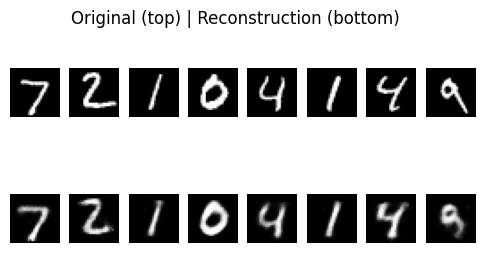

Epoch 2, Loss: 0.0135


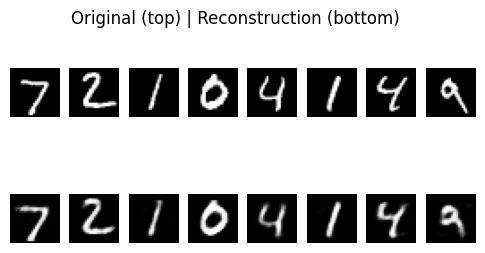

Epoch 3, Loss: 0.0096


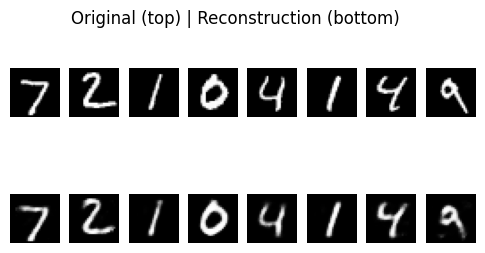

Epoch 4, Loss: 0.0077


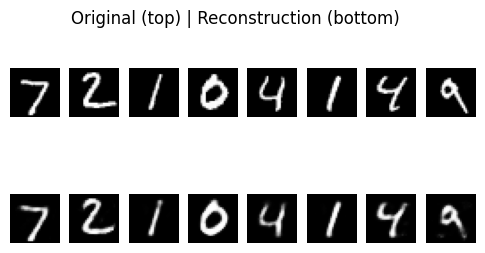

Epoch 5, Loss: 0.0066


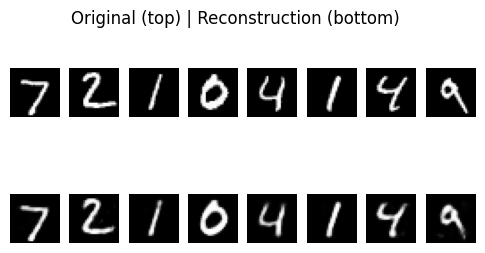

Epoch 6, Loss: 0.0059


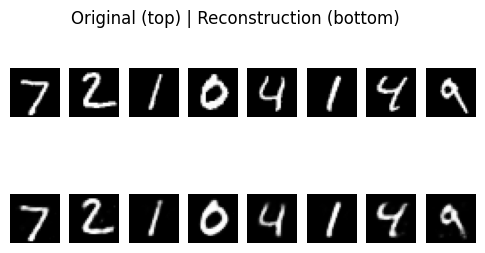

Epoch 7, Loss: 0.0053


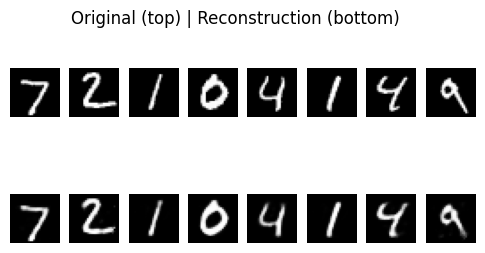

Epoch 8, Loss: 0.0049


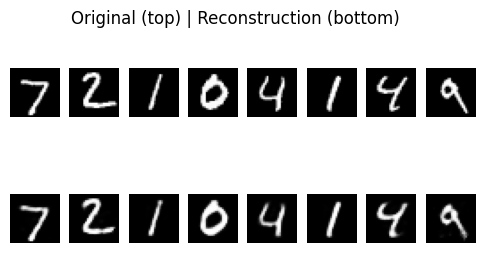

Epoch 9, Loss: 0.0045


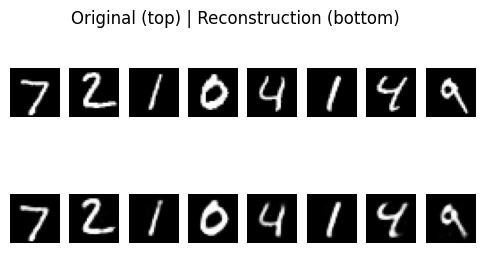

Epoch 10, Loss: 0.0043


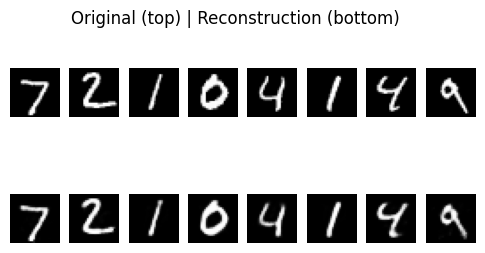

In [8]:
model = Autoencoder(img_dim, hidden_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, epochs+1):
    train(model, train_loader, optimizer, criterion, epoch)
    show_reconstruction(model, test_loader, n=8)

Au-delà du code:

L'autoencodeur apprend à:
- compresser une image en une représentation compacte (encodage)
- reconstruire l'image originale à partir de cette rerésentation (décodage)

Ca encode dans le ""bottleneck = espace latent"", dans cet espace à plus petite dimension les caractéristiques essentielles sont encodées: forme, courbure, épaisseur du trait, etc

A quoi peut servir l'autoencodeur:
- Compresser des données
- Débruiter des images, en prenant en entrée des images bruitées et des images propres en cible
- détection d'anomalies, si la loss est élevée pour certaines images !

Mettre un espace latent en 2 dimensions peut aider à visualiser car on peut facilement plot

### L'une des raisons pour laquelle on mets en place des Variational Autoencoders, c'est que **pour un autoencoder l'espace latent peut devenir disjoint et non-continue**.